# Reverse time migration example on a 2D  acoustic model

## Set up environment.

In [1]:
from ipyparallel import Client
c = Client(profile='mpi', debug=False)
dview = c[:]

with dview.sync_imports():
    import sys
    import numpy
    from examples.acoustic import demo_toolkit

# Plotting modules.
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

importing sys on engine(s)
importing numpy on engine(s)
importing demo_toolkit from examples.acoustic on engine(s)


## Load synthetic velocity model.

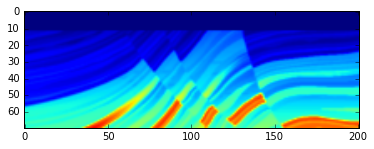

In [2]:
model = demo_toolkit.get_true_model()

# Plot true velocity
fig1 = plt.figure()
l = plt.imshow(numpy.transpose(model.vp), vmin=1.5, vmax=4, aspect=1)
plt.show()

## Create "initial guess" by smoothening the synthetic velocity model.

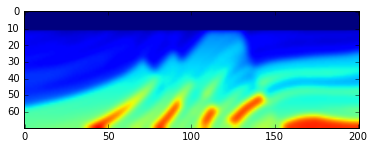

In [3]:
model0 = demo_toolkit.get_initial_model()

# Plot smooth velocity
fig2 = plt.figure()
l = plt.imshow(numpy.transpose(model0.vp), vmin=1.5, vmax=4, aspect=1)
plt.show()

## Example of a shot record

In [4]:
# %load_ext snakeviz

GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/d625745aa5a93a610bd8b0200963b861c324d1c2.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/624fbebf8ae059642e4a5ba5d60326f185de7230.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/f51e300d4be23861c75e847dcc0df48048b1bd1a.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/9c49731cd2b0d78e86138e45d5e5f811b0b0cca0.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/bfdfcf58f9e4fa9175a095af9614e191efadb04f.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/00069ad745956b514919862943c069c2fd3c4f25.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/1f45656fd4d95f17435e373dc22434f32ca36018.cpp
GNUCompiler: Compiling /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-501/89759be60369fc7c79bae

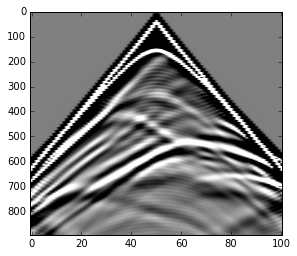

In [5]:
# %%snakeviz
data, rec = demo_toolkit.get_shot(50)

# Create acoustic modelling kernel.
from examples.acoustic.Acoustic_codegen import Acoustic_cg
Acoustic = Acoustic_cg(model0, data, t_order=2, s_order=10)

# Execute acoustic forward model.
rec0, u, gflopss, oi, timings = Acoustic.Forward(save=False, cse=True)

# Show the shot record at the receivers.
fig3 = plt.figure()
l = plt.imshow(rec0, vmin=-.1, vmax=.1, aspect=.1, cmap=cm.gray)
plt.show()

## RTM loop

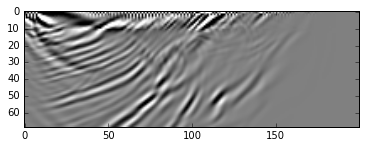

In [7]:
# %%snakeviz
def grad_shot(i):
    model0 = demo_toolkit.get_initial_model()
    data, rec = demo_toolkit.get_shot(i)

    Acoustic0 = demo_toolkit.Acoustic_cg(model0, data, t_order=2, s_order=4)
    rec0, u0, gflopss, oi, timings = Acoustic0.Forward(save=True, cse=True)

    # Return gradient
    return Acoustic0.Gradient(rec0 - rec, u0, cache_blocking=None)

grads = dview.map(grad_shot, range(4)) # problem_spec['nsrc']))

grad = sum(grads)

fig4 = plt.figure()
l = plt.imshow(numpy.diff(numpy.diff(numpy.transpose(grad[40:-40,40:-40]),1,0),1), 
               vmin=-100, vmax=100, aspect=1, cmap=cm.gray)
plt.show()